In [61]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from datetime import datetime as DT
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors
from cftime import date2num
from tqdm.notebook import tqdm
# Interactive plots
%matplotlib widget 
from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Paths, files
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray'
pc_root = '/home/mikapm/ROXSI/Asilomar2022/SmallScaleArray'
# nc file output
outdir = os.path.join(pc_root, 'Bicoherence')
sig_specdir = os.path.join(pc_root, 'Spectra_ENU')
# Check if outdir exists and if not create it
if not os.path.isdir(outdir):
    os.mkdir(outdir)
# Signature 1000 ADCP data
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
# Vector ADCP data
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')

# Start/end dates/times of experiment period
t0 = pd.Timestamp('2022-06-27 00:00') # Start date
t1 = pd.Timestamp('2022-07-14 10:00') # End date
# Make hourly time array
date_range = pd.date_range(t0, t1, freq='1D')

# Experiment vs. paper mooring IDs (Signatures and Vectors)
sig_mids = {'C1':'SO', 'C3':'SM', 'C6':'SI', 'L1':'SS', 'L5':'SN'}
vec_mids = {'C2':'VO', 'C3':'VM', 'C5':'VI', 'L1':'VS', 'L5':'VN'}

# Default Signature and Vector mooring ID colors
clss = {'C1':'#a70000', 'C3':'#ff5252', 'C6':'#ffbaba', 'L5':'gold'}
clsv = {'C2':'#0A369D', 'C3':'#92B4F4', 'C5':'#CFDEE7', 'L5':'darkturquoise'}

# Vector bursts to skip due to noisy data despite despiking (manually checked)
vec_skip = {'L1':[pd.Timestamp('2022-07-01 12:00:00'),
                  pd.Timestamp('2022-07-02 20:00:00'),
                  pd.Timestamp('2022-07-03 14:00:00'),
                  pd.Timestamp('2022-07-04 13:00:00'),
                  pd.Timestamp('2022-07-04 14:00:00'),
                  pd.Timestamp('2022-07-04 15:00:00'),
                  pd.Timestamp('2022-07-11 10:00:00'),
                  pd.Timestamp('2022-07-17 05:00:00'),
                  ],
            'L5':[pd.Timestamp('2022-07-02 19:00:00'),
                  ],
            'C2':[],
            'C3':[],
            'C5':[],
            }
# Reference date for netcdf timestamps
ref_date=pd.Timestamp('2000-01-01')

Estimate hourly bicoherence and concatenate to daily files.

In [38]:
# Estimate bicoherence for Sig surface elevation and Vec u for sample period
for i, (mid,ser) in enumerate(zip(['C1', 'C3', 'C6'], ['103088', '103094', '103110'])):
    print(f'Signature {mid}-{ser}')
    # Output netcdf filename
    fn_out = os.path.join(outdir, 'bicoherence_sig_{}.nc'.format(mid))
    if not os.path.isfile(fn_out):
        # Empty list for hourly bicoherence datasets for current date (for concatenating)
        bcl = []
        # Iterate over dates
        for d0 in tqdm(date_range):
            # Make hourly range array for current date
            time_range = pd.date_range(d0, d0+pd.Timedelta(days=1), freq='1h')[:-1]
            # Iterate over 1h segments
            for t0b in time_range:
                t1b = t0b + pd.Timedelta(hours=1) # Sample period end
                if t0b > t1:
                    # Don't go beyond end of experiment
                    continue
                # Read Signature velocity dataset
                sigdir = os.path.join(sig_root, '{}'.format(ser))
                fn_sig = os.path.join(sigdir, 'Asilomar_SSA_L1_Sig_Vel_{}_{}.nc'.format(
                    mid, str(t0b.date().strftime('%Y%m%d'))))
                dss = xr.open_dataset(fn_sig, decode_coords='all')
                # Take out burst segment
                segs = dss.sel(time=slice(t0b, t1b)).copy()
                depth = dss.z_hyd.mean().item()

                # Parameters for Gaussian filter
                sigma = 2
                winsz = 5
                truncate = (((winsz - 1)/2)-0.5)/sigma
                # Bicoherence
                _, dbcs = rpws.bispectrum(segs.ASTd_eta.values, fs=4, fmerge=3, wsec=128,
                                        return_bicoh=True, return_krms=False)
                # Remove (complex) bispectrum array from dataset
                vars_to_keep = ['Bc', 'dof', 'b99', 'b95', 'b90', 'b80']
                dbcs = dbcs[vars_to_keep]
                # Apply Gaussian filter to bicoherence
                bc = dbcs.Bc.values
                bc[bc < dbcs.b99.item()] = 0 # Set to zero values < 99% confidence int.
                bg = gaussian_filter(bc**2, sigma=sigma, truncate=truncate) # Filter bicoherence
                # bg = gaussian_filter(bc, sigma=sigma, truncate=truncate) # Filter bicoherence
                # Add filtered array to dataset
                dbcs['bcf'] = (['freq1', 'freq2'], bg)
                # Replace 'raw' bicoherence with unfiltered Bc**2
                dbcs['bc'] = (['freq1', 'freq2'], dbcs.Bc.values**2)
                vars_to_keep = ['bc', 'bcf', 'dof', 'b99', 'b95', 'b90', 'b80']
                dbcs = dbcs[vars_to_keep]

                # Add time coordinate to dataset
                # Convert time array to numerical format
                time_units = 'seconds since {:%Y-%m-%d 00:00:00}'.format(ref_date)
                time = pd.to_datetime(t0b).to_pydatetime()
                time_vals = date2num(time, 
                                    time_units, calendar='standard', 
                                    has_year_zero=True)
                dbcs.coords['time'] = time_vals.astype(float)
                dbcs.time.encoding['units'] = time_units
                dbcs.time.attrs['units'] = time_units
                dbcs.time.attrs['standard_name'] = 'time'
                dbcs.time.attrs['long_name'] = 'Local time (PDT) of bispectral segment start'

                # Append dataset to list for daily concatenating
                bcl.append(dbcs)
            
        # Concatenate daily bicoherence datasets for current Signature
        print('Concatenating and saving bicoherence arrays ... \n')
        dsb = xr.concat(bcl, dim='time')
        # Save to netcdf
        dsb.to_netcdf(fn_out)




# Vector ucs-bicoherence
for i, (mid,ser) in enumerate(zip(['C2', 'C3', 'C5'], ['17212', '17219', '17372'])):
    print(f'Vector {mid}-{ser}')
    # Output netcdf filename
    fn_out = os.path.join(outdir, 'bicoherence_vec_{}.nc'.format(mid))
    if not os.path.isfile(fn_out):
        # Empty list for hourly bicoherence datasets for current date (for concatenating)
        bcl = []
        # Iterate over dates
        for d0 in tqdm(date_range):
            # Make hourly range array for current date
            time_range = pd.date_range(d0, d0+pd.Timedelta(days=1), freq='1h')[:-1]
            # Iterate over 1h segments
            for t0b in time_range:
                t1b = t0b + pd.Timedelta(hours=1) # Sample period end
                if t0b > t1:
                    # Don't go beyond end of experiment
                    continue
                # Read Vector netcdf file
                ncdir = os.path.join(vec_root, mid)
                fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(ser, 
                    str(t0b.date().strftime('%Y%m%d'))))
                dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
                # Select sample period
                seg = dsv.sel(time=slice(t0b, t1b))
                # Check for fraction of spikes in Vector burst
                spikes_frac_x = np.sum(~np.isclose(seg.ux, seg.uxd)) / len(seg.uz)
                spikes_frac_y = np.sum(~np.isclose(seg.uy, seg.uyd)) / len(seg.uz)
                spikes_frac_z = np.sum(~np.isclose(seg.uz, seg.uzd)) / len(seg.uz)
                # Max fraction of spikes = 0.2
                if spikes_frac_x>0.2 or spikes_frac_y>0.2 or spikes_frac_z>0.2:
                    continue
                # Check if burst should be skipped due to manual inspection
                if t0b in vec_skip[mid]:
                    continue
                # Get sea-surface elevation (K_rms transform)
                eta = seg.eta_lin_krms.copy().to_series() # Surface elevation
                depth = seg.z_hyd.mean().item() # water depth
                # Convert velocities to cross-/alongshore
                if mid in ['L1', 'L5']:
                    # x vel, despiked
                    uxd = seg.uxd.to_dataframe() # Convert to pandas
                    uxd = uxd.interpolate(method='bfill').interpolate('ffill')
                    uxm = uxd.mean().item()
                    uxd -= uxm # Remove mean
                    # uxd -= uxm
                    # y vel, despiked
                    uyd = seg.uyd.to_dataframe() # Convert to pandas
                    uyd = uyd.interpolate(method='bfill').interpolate('ffill')
                    uym = uyd.mean().item()
                    uyd -= uym # Remove mean
                    # uyd -= uym
                    # z vel, despiked
                    uzd = seg.uzd.to_dataframe() # Convert to pandas
                    uzd = uzd.interpolate(method='bfill').interpolate('ffill')
                    uzm = uzd.mean().item()
                    uzd -= uzm # Remove mean
                    # uzd -= uzd.mean()
                    # Rotate velocities to cross/alongshore & vertical using PCA
                    ucs, uls, uw = rpct.enu_to_loc_pca(ux=uxd.values.squeeze(), 
                                                    uy=uyd.values.squeeze(), 
                                                    uz=uzd.values.squeeze(),
                                                    # print_msg=True,
                                                    )
                    # Check that ucs is in the right (shoreward) direction by computing 
                    # mean wave direction from directional wave spectrum
                    dssu = rpws.spec_uvz(z=eta.values, u=ucs, v=uls, fs=16, fmerge=5)
                    # If mdir close to 90 deg -> flip velocities
                    if abs(dssu.mdir.item() - 270) > 90:
                        ucs *= (-1)
                        uls *= (-1)
                        uw *= (-1)
                else:
                    # Convert E,N velocities to local cross- & alongshore 
                    uE = seg.uE.to_dataframe() # Convert to pandas
                    uE = uE.interpolate(method='bfill').interpolate('ffill')
                    uE -= uE.mean() # Remove mean
                    uN = seg.uN.to_dataframe() # Convert to pandas
                    uN = uN.interpolate(method='bfill').interpolate('ffill')
                    uN -= uN.mean() # Remove mean
                    uU = seg.uU.to_dataframe() # Convert to pandas
                    uU = uU.interpolate(method='bfill').interpolate('ffill')
                    dss_seg = rpws.spec_uvz(z=eta.values, 
                                            u=uE.values.squeeze(), 
                                            v=uN.values.squeeze(), 
                                            fs=16,
                                            fmerge=5,
                                            )
                    # Convert to cross-alongshore based on mean wave direction
                    angle_met = dss_seg.mdir.item() # Cross-shore angle
                    angle_math = 270 - angle_met # Math angle to rotate
                    if angle_math < 0:
                        angle_math += 360
                    angle_math = np.deg2rad(angle_math) # Radians
                    # Rotate East and North velocities to cross-shore (cs) and 
                    # long-shore (ls)
                    ucs, uls = rpct.rotate_vel(uE.values.squeeze(), 
                                            uN.values.squeeze(), 
                                            angle_math,
                                            )
                    uw = uU.values.squeeze() # Vertical vel.
                # Bicoherence (downsample to 4Hz and average)
                bca = [] # Empty list for averaging downsampled bicoherence arrays
                for di in range(4):
                    _, dbcv = rpws.bispectrum(ucs[di::4], fs=4, fmerge=3, wsec=128,
                                              return_bicoh=True, return_krms=False)
                    # Set to zero non-significant values of bicoherence
                    bc = dbcv.Bc.values # array format
                    bc[bc < dbcv.b99.item()] = 0 # Set to 0 values < 99% significance
                    # Append to list for avging
                    bca.append(bc)
                # Average bicoherence
                bc = np.array(bca).mean(axis=0)
                # Filter
                bg = gaussian_filter(bc**2, sigma=sigma, truncate=truncate)
                # Add filtered array to dataset
                dbcv['bcf'] = (['freq1', 'freq2'], bg**2)
                # Replace 'raw' bicoherence with unfiltered Bc**2
                dbcv['bc'] = (['freq1', 'freq2'], dbcv.Bc.values**2)
                vars_to_keep = ['bc', 'bcf', 'dof', 'b99', 'b95', 'b90', 'b80']
                dbcv = dbcv[vars_to_keep]

                # Add time coordinate to dataset
                # Convert time array to numerical format
                time_units = 'seconds since {:%Y-%m-%d 00:00:00}'.format(ref_date)
                time = pd.to_datetime(t0b).to_pydatetime()
                time_vals = date2num(time, 
                                     time_units, calendar='standard', 
                                     has_year_zero=True,
                                     )
                dbcv.coords['time'] = time_vals.astype(float)
                dbcv.time.encoding['units'] = time_units
                dbcv.time.attrs['units'] = time_units
                dbcv.time.attrs['standard_name'] = 'time'
                dbcv.time.attrs['long_name'] = 'Local time (PDT) of bispectral segment start'

                # Append dataset to list for daily concatenating
                bcl.append(dbcv)

        # Concatenate daily bicoherence datasets for current Signature
        print('Concatenating and saving bicoherence arrays for Vectors ... \n')
        dsb = xr.concat(bcl, dim='time')
        # Save to netcdf
        dsb.to_netcdf(fn_out)


Signature C1-103088
Signature C3-103094
Signature C6-103110
Vector C2-17212


  0%|          | 0/18 [00:00<?, ?it/s]

Concatenating and saving bicoherence arrays for Vectors ... 

Vector C3-17219


  0%|          | 0/18 [00:00<?, ?it/s]

Concatenating and saving bicoherence arrays for Vectors ... 

Vector C5-17372


  0%|          | 0/18 [00:00<?, ?it/s]

Concatenating and saving bicoherence arrays for Vectors ... 



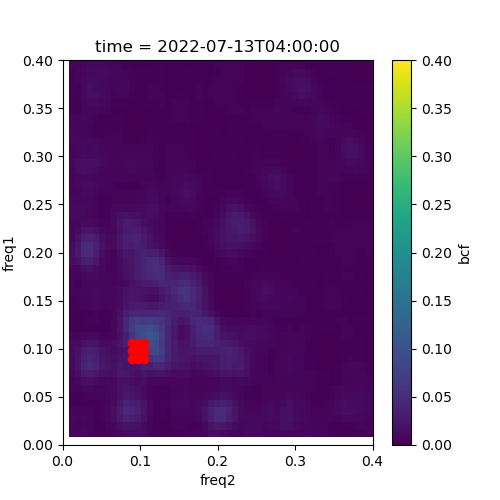

In [52]:
dsb = xr.open_dataset(fn_out, decode_coords='all')
fig, ax = plt.subplots(figsize=(5,5))
dsb.sel(time=pd.Timestamp('2022-07-13 04:00')).bcf.plot.pcolormesh(ax=ax, vmin=0, vmax=0.4)
ax.set_xlim([0, 0.4])
ax.set_ylim([0, 0.4])
fp = 0.1
absf1 = np.abs(dsb.freq1-fp)
absf2 = np.abs(dsb.freq2-fp)
c = np.maximum(absf1, absf2)
([f1], [f2]) = np.where(c == np.min(c))
ax.scatter(dsb.freq1.isel(freq1=f1), dsb.freq2.isel(freq2=f2), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1-1), dsb.freq2.isel(freq2=f2), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1+1), dsb.freq2.isel(freq2=f2), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1-1), dsb.freq2.isel(freq2=f2-1), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1+1), dsb.freq2.isel(freq2=f2-1), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1), dsb.freq2.isel(freq2=f2-1), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1), dsb.freq2.isel(freq2=f2+1), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1+1), dsb.freq2.isel(freq2=f2+1), color='r')
ax.scatter(dsb.freq1.isel(freq1=f1-1), dsb.freq2.isel(freq2=f2+1), color='r')

plt.show()

In [64]:
df_sig = {} # Empty dict to store Signature bicoh vs fp dataframes
for i, (mid,ser) in enumerate(zip(['C1', 'C3', 'C6'], ['103088', '103094', '103110'])):
    print(f'Signature {mid}-{ser}')
    # Bicoherence netcdf filename
    fn = os.path.join(outdir, 'bicoherence_sig_{}.nc'.format(mid))
    dsb = xr.open_dataset(fn, decode_coords='all')
    # Signature spectral netcdf
    fn_spec = os.path.join(sig_specdir,  'Asilomar_2022_SSA_Signature_{}_spec_AST_ENU.nc'.format(
        ser))
    dss = xr.open_dataset(fn_spec, decode_coords='all')
    bp = [] # List for bicoh values around fp
    bp2 = [] # List for bicoh values around fp*2
    bp3 = [] # List for bicoh values around fp*3
    ts = [] # List for timestamps
    hs = [] # List for Hs
    d = [] # List for depths
    kp = [] # List for kp
    # Iterate over hours in bicoherence dataset
    for t0s in dsb.time.values:
        # Get current peak freq from spectrum
        fp = dss.fp.sel(time=t0s).values.item()
        # Find nearest bicoherence frequency to fp
        absf1 = np.abs(dsb.freq1-fp)
        absf2 = np.abs(dsb.freq2-fp)
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest fp inds
        # Compute avg bicoherence around fp and harmonics
        bc_fp = dsb.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
        # Find nearest bicoherence frequency to fp*2
        absf1 = np.abs(dsb.freq1-fp*2)
        absf2 = np.abs(dsb.freq2-fp*2)
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest fp inds
        # Compute avg bicoherence around fp and harmonics
        bc_2fp = dsb.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
        # Find nearest bicoherence frequency to fp*3
        absf1 = np.abs(dsb.freq1-fp*3)
        absf2 = np.abs(dsb.freq2-fp*3)
        c = np.maximum(absf1, absf2)
        ([f1], [f2]) = np.where(c == np.min(c)) # nearest fp inds
        # Compute avg bicoherence around fp and harmonics
        bc_3fp = dsb.sel(time=t0s).isel(freq1=slice(f1-1,f1+2), freq2=slice(f2-1,f2+2)).mean(dim=['freq1','freq2'])
        # Append to list
        bp.append(bc_fp)
        bp2.append(bc_2fp)
        bp3.append(bc_3fp)
    # Save computed values in dataframe for current signature
    dfi = pd.DataFrame()




Signature C1-103088
Signature C3-103094
Signature C6-103110
